In [8]:
# The following pytorch code is based on
# https://github.com/snowbbbb/code-for-Global-Convergence-of-Over-parameterized-Deep-Equilibrium-Models

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import os
import torch.nn.functional as F
import random
from torch.utils.data import TensorDataset
import torch.autograd as autograd
from torch.utils.data import ConcatDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

'''
SEED = 2
torch.manual_seed(SEED)
random.seed(SEED)　　 
torch.cuda.manual_seed(SEED) 
torch.backends.cudnn.deterministic = True
'''

'\nSEED = 2\ntorch.manual_seed(SEED)\nrandom.seed(SEED)\u3000\u3000 \ntorch.cuda.manual_seed(SEED) \ntorch.backends.cudnn.deterministic = True\n'

In [75]:
root_train = '/Users/lantruong/Dataset/CIFAR10/'
trainTransform = transforms.Compose([transforms.Grayscale(1),
                                transforms.ToTensor()])
                               
trainset_full = torchvision.datasets.CIFAR10(root_train, train = True, download = True, transform = trainTransform)

idx = (trainset_full.targets=='airplane')
trainset_full.targets = trainset_full.targets[idx]
trainset_full.data = trainset_full.data[idx]
trainset0 = torch.utils.data.Subset(trainset_full, range(500))

trainset_full = torchvision.datasets.CIFAR10(root_train, train = True, download = True, transform = trainTransform)

idx = (trainset_full.targets=='automobile')
trainset_full.targets = trainset_full.targets[idx]
trainset_full.data = trainset_full.data[idx]
trainset1 = torch.utils.data.Subset(trainset_full, range(500))

trainset=torch.utils.data.ConcatDataset([trainset0,trainset1])


Files already downloaded and verified
Files already downloaded and verified


In [77]:
########################################################################
# Download and define the training set.

samplesize = 10000
netDepth = 2

trainloader = torch.utils.data.DataLoader(trainset_full, batch_size=len(trainset), shuffle=True)
batchsize=1000
dataiter = iter(trainloader)
images, labels =next(dataiter)
images=torch.flatten(images,start_dim=1)
images = F.normalize(images, p=2, dim=1)
allLabel =torch.rand(1000)
train_ids = TensorDataset(images, allLabel)
trainloader = torch.utils.data.DataLoader(dataset=train_ids, batch_size=len(train_ids), shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

output_size=1

In [78]:
def FPiter(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta=1.0):
    #Anderson acceleration for fixed point iteration
    bsz, D = x0.shape
    X = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    X[:, 0], F[:, 0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:, 1], F[:, 1] = F[:, 0], f(F[:, 0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m + 1, m + 1, dtype=x0.dtype, device=x0.device)
    H[:, 0, 1:] = H[:, 1:, 0] = 1
    y = torch.zeros(bsz, m + 1, 1, dtype=x0.dtype, device=x0.device)
    y[:, 0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:, :n] - X[:, :n]
        H[:, 1:n + 1, 1:n + 1] = torch.bmm(G, G.transpose(1, 2)) + lam * torch.eye(n, dtype=x0.dtype, device=x0.device)[
            None]
        alpha = torch.linalg.solve(H[:, :n + 1, :n + 1],y[:, :n + 1])[:, 1:n + 1, 0]  # (bsz x n)

        X[:, k % m] = beta * (alpha[:, None] @ F[:, :n])[:, 0] + (1 - beta) * (alpha[:, None] @ X[:, :n])[:, 0]
        F[:, k % m] = f(X[:, k % m].view_as(x0)).view(bsz, -1)
        res.append((F[:, k % m] - X[:, k % m]).norm().item() / (1e-5 + F[:, k % m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:, k % m].view_as(x0), res

In [79]:
class Net(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   


    def forward(self, z, x):
        y = F.sigmoid(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [80]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z: self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z, x)

        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0, x)

        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y: autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g

        z.register_hook(backward_hook)
        return z

In [81]:
def get_jacobian(model, x):
    nc = x.size()[0]
    ny = x.size()[2]
    nx = x.size()[1]
    noutputs = 10
    x = x.reshape(nc * nx * ny)
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = model(x.reshape(noutputs, nc, nx, ny))
    y.backward(torch.eye(noutputs).to(device))
    return x.grad.data

In [82]:
def setup_and_train(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = Net(width, Wstd)
    linear_input = nn.Linear(1 *  32 * 32, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot   

In [ ]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001

width=3000
loss_plot3000=setup_and_train(epochs, lr, 3000, Wstd)

width=4000
loss_plot4000=setup_and_train(epochs, lr, 4000, Wstd)

width=5000
loss_plot5000=setup_and_train(epochs, lr, 5000, Wstd)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


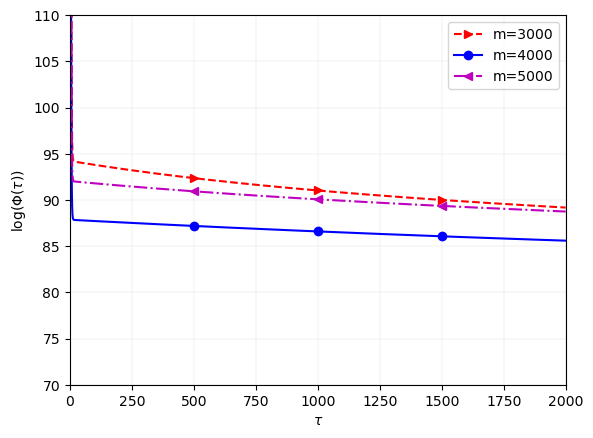

In [137]:
plt.figure(1)
plt.plot(range(epochs), loss_plot3000,'r--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot4000,'b-',marker='o',markevery=500)
plt.plot(range(epochs), loss_plot5000,'m-.',marker='<',markevery=500)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['m=3000','m=4000','m=5000'])
plt.axis([0,2000,70,110])
plt.savefig('code_DEM_CIFAR10.pdf') 
plt.savefig('code_DEM_CIFAR10.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)



In [95]:
class NetReLU(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   #nn.normal的参数中std是标准差 正态分布N(u,d^2)  方差为d^2,标准差为d，


    def forward(self, z, x):
        y = F.relu(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [96]:
def setup_and_train_ReLU(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetReLU(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [ ]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000ReLU=setup_and_train(epochs, lr, 3000, Wstd)

In [102]:
class NetTANH(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   


    def forward(self, z, x):
        y = F.tanh(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [103]:
def setup_and_train_ReLU(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetTANH(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [ ]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000tanh=setup_and_train(epochs, lr, 3000, Wstd)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


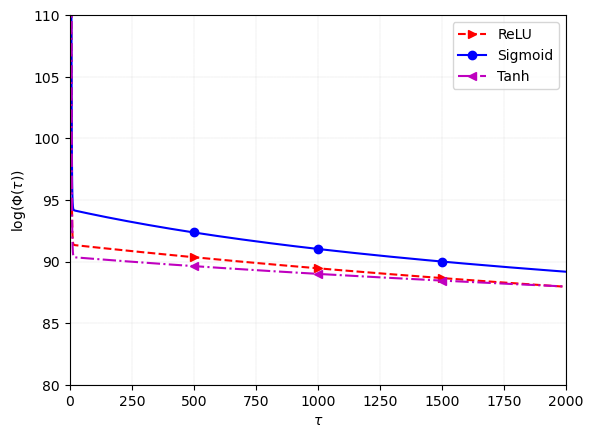

In [135]:
plt.figure(2)
plt.plot(range(epochs), loss_plot3000ReLU,'r--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot3000,'b-',marker='o',markevery=500)
plt.plot(range(epochs), loss_plot3000tanh,'m-.',marker='<',markevery=500)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['ReLU','Sigmoid','Tanh'])
plt.savefig('L2loss_mnist_'+str(width)+'_'+str(Wstd)+'.png')
plt.axis([0,2000,80,110])
plt.savefig('code_DEM_comp_cifar.pdf') 
plt.savefig('code_DEM_comp_cifar.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)